In [2]:
#import mysql
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split


## Downloand database

In [3]:
# def connect_to_database():
#     try:
#         with open('secret.txt', 'r') as file:
#             connection = mysql.connector.connect(
#                 host='localhost',
#                 database='magic_cards',
#                 user='root',
#                 password=file.readline()
#             )
#         if connection.is_connected():
#             print("Connected to MySQL database")
#             return connection
#     except mysql.connector.Error as e:
#         print(f"Error while connecting to MySQL: {e}")
#     return None

# def export_to_csv(connection, filename='magic_cards.csv'):
#     query = """
#     SELECT name, colorIdentity, keywords, supertypes
#     FROM cards
#     """
#     df = pd.read_sql(query, connection)
#     df.to_csv(filename, index=False)
#     print(f"Data exported to {filename}")



In [4]:
# Main execution
# connection = connect_to_database()
# if connection:
#     export_to_csv(connection)
#     connection.close()
# else:
#     print("Failed to connect to the database.")

## Analysis portion

In [3]:
def load_card_data(filename='cards.csv'):
    return pd.read_csv(filename)

def prepare_features(df):
    # Process colors
    color_map = {'W': 'White', 'U': 'Blue', 'B': 'Black', 'R': 'Red', 'G': 'Green'}
    df['colorIdentity'] = df['colorIdentity'].fillna('').apply(lambda x: [color_map.get(c.strip(), c.strip()) for c in x.split(',')] if isinstance(x, str) else [])
    mlb_colors = MultiLabelBinarizer()
    color_features = pd.DataFrame(
        mlb_colors.fit_transform(df['colorIdentity']),
        columns=mlb_colors.classes_,
        index=df.index
    )
    
    # Process keywords
    df['keywords'] = df['keywords'].fillna('').apply(lambda x: [kw.strip() for kw in x.split(',')] if isinstance(x, str) else [])
    mlb_keywords = MultiLabelBinarizer()
    keyword_features = pd.DataFrame(
        mlb_keywords.fit_transform(df['keywords']),
        columns=mlb_keywords.classes_,
        index=df.index
    )
    
    # Process supertypes
    df['is_legendary'] = df['supertypes'].fillna('').str.contains('Legendary')
    
    # Combine features
    features = pd.concat([color_features, keyword_features, df[['is_legendary']]], axis=1)
    
    return features, mlb_colors, mlb_keywords

def cluster_cards(features, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=69, n_init=10)
    return kmeans.fit_predict(features)

def find_related_cards(df, features, legendary_card_name, top_n=1000):
    legendary_card = df[df['name'] == legendary_card_name].index[0]
    legendary_features = features.iloc[legendary_card].values.reshape(1, -1)
    
    similarities = cosine_similarity(legendary_features, features)
    similar_indices = similarities[0].argsort()[::-1][1:top_n+1]
    
    return df.iloc[similar_indices]

In [4]:
df_raw = load_card_data()
features, mlb_colors, mlb_keywords = prepare_features(df_raw)

/var/folders/zr/73hg6l9j7p739_l5lp2w946w0000gn/T/ipykernel_42262/3459460400.py:2: DtypeWarning: Columns (3,7,12,16,20,23,25,26,31,32,33,35,39,40,41,47,52,53,61,62,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filename)


In [5]:
#cleans up data frame by removing unwanted columns 
def card_cleanup(df):
    #removes warning statement of fills
    pd.set_option('future.no_silent_downcasting', True)

    keep_params = ['colorIdentity', 'colors', 'edhrecRank',
                   'edhrecSaltiness', 'hasAlternativeDeckLimit',
                    'isReserved', 'keywords', 'layout',
                   'manaCost', 'manaValue', 'name', 'power',
                   'subtypes', 'supertypes', 'text', 'toughness',
                   'type', 'types', 'is_legendary',
                   'rarity', ]
    df_out = df[keep_params]
    #fixes Nans for strings
    df_out.loc[:, 'text'] = df_out['text'].fillna('').infer_objects(copy=False)

    #fixes Nans for boolean values
    df_out.loc[:, 'hasAlternativeDeckLimit'] = df_out['hasAlternativeDeckLimit'].fillna(False).infer_objects(copy=False) #assumes NA means it doesnt have a deck limit, aka false
    df_out.loc[:, 'isReserved'] = df_out['isReserved'].fillna(False).infer_objects(copy=False) #assumes NA means it isnt reserved
    
    #fixes nans for numeric
    #-1 symbolizes the data is not valid (ie, a sorcerydoesn't have toughness so it is set to -1)
    df_out.loc[:, 'edhrecRank'] = df_out['edhrecRank'].fillna(-1).infer_objects(copy=False)
    df_out.loc[:, 'edhrecSaltiness'] = df_out['edhrecSaltiness'].fillna(-1).infer_objects(copy=False)
    df_out.loc[:, 'toughness'] = df_out['toughness'].fillna(-1).infer_objects(copy=False)

    #others
    #special logic needed to set list to empty
    df_out.loc[:, 'subtypes'] = df_out['subtypes'].apply(lambda x: [] if pd.isna(x) else x)
    df_out.loc[:, 'supertypes'] = df_out['supertypes'].apply(lambda x: [] if pd.isna(x) else x)
    df_out.loc[:, 'colors'] = df_out['colors'].apply(lambda x: [] if pd.isna(x) else x)

    return df_out

In [6]:
df = card_cleanup(df_raw)

In [ ]:
df[df['name'] == "Yuriko, the Tiger's Shadow"]

,colorIdentity,colors,edhrecRank,edhrecSaltiness,hasAlternativeDeckLimit,isReserved,keywords,layout,manaCost,manaValue,name,power,subtypes,supertypes,text,toughness,type,types,is_legendary,rarity
779,[],[],1.0,1.25,False,False,[],normal,{1},1.0,Sol Ring,NaN,[],[],{T}: Add {C}{C}.,-1,Artifact,Artifact,False,uncommon
1905,[],[],1.0,1.25,False,False,[],normal,{1},1.0,Sol Ring,NaN,[],[],{T}: Add {C}{C}.,-1,Artifact,Artifact,False,common
2040,[],[],1.0,1.25,False,False,[],normal,{1},1.0,Sol Ring,NaN,[],[],{T}: Add {C}{C}.,-1,Artifact,Artifact,False,uncommon
2202,[],[],1.0,1.25,False,False,[],normal,{1},1.0,Sol Ring,NaN,[],[],{T}: Add {C}{C}.,-1,Artifact,Artifact,False,common
2337,[],[],1.0,1.25,False,False,[],normal,{1},1.0,Sol Ring,NaN,[],[],{T}: Add {C}{C}.,-1,Artifact,Artifact,False,uncommon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92035,[],[],1.0,1.25,False,False,[],normal,{1},1.0,Sol Ring,NaN,[],[],{T}: Add {C}{C}.,-1,Artifact,Artifact,False,uncommon
94103,[],[],1.0,1.25,False,False,[],normal,{1},1.0,Sol Ring,NaN,[],[],{T}: Add {C}{C}.,-1,Artifact,Artifact,False,uncommon
94711,[],[],1.0,1.25,False,False,[],normal,{1},1.0,Sol Ring,NaN,[],[],{T}: Add {C}{C}.,-1,Artifact,Artifact,False,uncommon
95197,[],[],1.0,1.25,False,False,[],normal,{1},1.0,Sol Ring,NaN,[],[],{T}: Add {C}{C}.,-1,Artifact,Artifact,False,uncommon


In [10]:
# Perform clustering
clusters = cluster_cards(features)
df['cluster'] = clusters

/var/folders/zr/73hg6l9j7p739_l5lp2w946w0000gn/T/ipykernel_1525/2515153287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clusters


In [11]:
df.head()

,colorIdentity,colors,edhrecRank,edhrecSaltiness,hasAlternativeDeckLimit,isReserved,keywords,layout,manaCost,manaValue,...,power,subtypes,supertypes,text,toughness,type,types,is_legendary,rarity,cluster
0,[White],W,22093.0,-1.00,False,False,[First strike],normal,{5}{W}{W},7.0,...,4,"Human, Cleric",[],First strike (This creature deals combat damag...,4,Creature — Human Cleric,Creature,False,uncommon,7
1,[White],W,22093.0,-1.00,False,False,[First strike],normal,{5}{W}{W},7.0,...,4,"Human, Cleric",[],First strike (This creature deals combat damag...,4,Creature — Human Cleric,Creature,False,uncommon,7
2,[White],W,18221.0,0.12,False,False,[Flying],normal,{4}{W},5.0,...,3,Angel,[],"Flying\nWhen Angel of Mercy enters, you gain 3...",3,Creature — Angel,Creature,False,uncommon,7
3,[White],W,18221.0,0.12,False,False,[Flying],normal,{4}{W},5.0,...,3,Angel,[],"Flying\nWhen Angel of Mercy enters, you gain 3...",3,Creature — Angel,Creature,False,uncommon,7
4,[White],W,23854.0,0.12,False,False,[],normal,{2}{W},3.0,...,NaN,[],[],Target creature gets +3/+3 and gains flying un...,-1,Sorcery,Sorcery,False,common,1


In [12]:
print("Sample of clustered cards:")
print(df[['name', 'colorIdentity', 'keywords', 'is_legendary', 'cluster']].head(5))

Sample of clustered cards:
                name colorIdentity        keywords  is_legendary  cluster
0  Ancestor's Chosen       [White]  [First strike]         False        7
1  Ancestor's Chosen       [White]  [First strike]         False        7
2     Angel of Mercy       [White]        [Flying]         False        7
3     Angel of Mercy       [White]        [Flying]         False        7
4   Angelic Blessing       [White]              []         False        1


In [13]:
# Find related cards for a legendary creature
legendary_card_name = "Reya Dawnbringer"  # An example from your data
if legendary_card_name in df['name'].values:
    related_cards = find_related_cards(df, features, legendary_card_name)
    pd.set_option('display.max_rows', None)
    print(f"\nCards related to {legendary_card_name}:")
    print(related_cards[['name', 'colorIdentity', 'keywords', 'is_legendary', 'text']])
else:
    print(f"Legendary creature '{legendary_card_name}' not found in the database.")


Cards related to Reya Dawnbringer:
                                                    name   colorIdentity  \
13059                         Teshar, Ancestor's Apostle         [White]   
26166                                Zeriam, Golden Wind         [White]   
20525                         Teshar, Ancestor's Apostle         [White]   
76342                        Mavinda, Students' Advocate         [White]   
26242                                Zeriam, Golden Wind         [White]   
85668                        Mavinda, Students' Advocate         [White]   
79694                         Linvala, Keeper of Silence         [White]   
87725                                        Major Teroh         [White]   
76343                        Mavinda, Students' Advocate         [White]   
49                                      Reya Dawnbringer         [White]   
48                                      Reya Dawnbringer         [White]   
26677                                  Lieutenant Ki

In [14]:
# Print some statistics
print("\nCluster Statistics:")
print(df['cluster'].value_counts())

print("\nMost common keywords:")
print(df['keywords'].explode().value_counts().head(10))

print("\nColor distribution:")
print(df['colorIdentity'].explode().value_counts())


Cluster Statistics:
cluster
0    17077
6    15611
2    13611
4    10813
3    10324
1    10252
7     6593
8     6157
9     4250
5     3004
Name: count, dtype: int64

Most common keywords:
keywords
             57285
Flying        8811
Enchant       3294
Trample       2441
Haste         1784
Vigilance     1675
Equip         1463
Mill          1427
Flash         1384
Scry          1345
Name: count, dtype: int64

Color distribution:
colorIdentity
Green    22038
Black    21896
White    21690
Blue     21666
Red      21650
         10813
Name: count, dtype: int64


In [15]:
cards = pd.read_csv('cards.csv')
with open('Keywords.json') as json_file:
    keywords = json.load(json_file)

#load dict of all keywords
keywords = pd.DataFrame({'keywords': keywords})

#split rules text into all possible permutations, then do this for each candidate and compare amount of matching options to increase support
def split_rules(rules_text):
    splits = []
    #split at first occurrence and store, then second, and so on. then iterate and do it again
    parsed_rules = rules_text.split("\\n")[-1].split(" ")

    for i in range(len(parsed_rules)):
        cut_rules = " ".join(parsed_rules[:len(parsed_rules) - i])
        for j in range(len(cut_rules.split(" "))):
            #split at last occurrence, then take the first value in split to get full string
            sliced_rules = cut_rules.split("\\n")[-1].split(" ", j)
            # for j in range(len(bruh) - i):
            splits.append(sliced_rules[-1])
    return splits

def create_candidates(ref_name, related_cards):
    # print(ref_name)
    candidates = []

    rules_matrix = []

    for text in related_cards['text'].tolist():
        rules_matrix.append(split_rules(text))
        
    for i in range(len(rules_matrix)):
        if len(set(rules_matrix[0]) & set(rules_matrix[i])) > 2 and len(candidates) < 62 and (related_cards['name'].tolist()[i], rules_matrix[i][0], len(set(rules_matrix[0]) & set(rules_matrix[i]))) not in candidates:
            #currently only preserving name during testing
            candidates.append((related_cards['name'].tolist()[i], rules_matrix[i][0], len(set(rules_matrix[0]) & set(rules_matrix[i]))))
            #candidates += create_candidates(related_cards['name'].tolist()[i], related_cards)

    return candidates


cell_value = cards.where(cards=='Reya Dawnbringer').dropna(how='all').dropna(axis=1)
# print(related_cards[['name', 'text']])
#increase support value based on shared keywords, shared terms in rules text, and triggers
pd.set_option('display.max_colwidth', None)
#print(cards.loc[cell_value.index[-1], 'text']) 
# rules = split_rules(cards.loc[cell_value.index[-1], 'text'])

candidates = create_candidates(legendary_card_name, related_cards)
print(len(candidates))

/var/folders/zr/73hg6l9j7p739_l5lp2w946w0000gn/T/ipykernel_1525/647909955.py:1: DtypeWarning: Columns (3,7,12,16,20,23,25,26,31,32,33,35,39,40,41,47,52,53,61,62,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  cards = pd.read_csv('cards.csv')


62


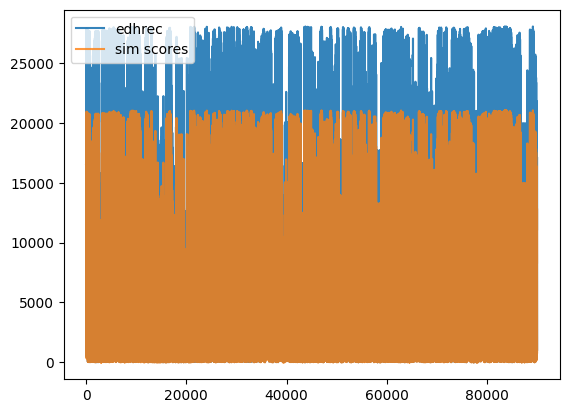

In [ ]:
#generates random sim score for now for testing

#drops ehrec ranks that don't exist
df = df[df.edhrecRank != -1]
#converts edhrec to a np array and then creates a random sim score for each row loosely based on edhrec
df_edhrec = np.array(df['edhrecRank'].tolist())
df_sim_score = [0.75 * x + random.gauss(0, 10) for x in df_edhrec]

#plots
# plt.plot(df_edhrec, label = 'edhrec', alpha = 0.9)
# plt.plot(df_sim_score, label = 'sim scores', alpha = 0.8)
# plt.legend()



In [ ]:
class SimpleLinearRegression:
    def __init__(self):
        #initializes variables
        self.slope_ = None
        self.intercept_ = None
        
    def fit(self, x, y):
        #calculates the mean of the input and labels
        Xmean = np.mean(x)
        ymean = np.mean(y)
        
        #calculate terms needed for slope and intercept of regression line
        numerator = np.sum((x - Xmean) * (y - ymean))
        denominator = np.sum((x - Xmean) ** 2)

        #calculate slope and intercept of regression line
        self.slope_ = numerator / denominator
        self.intercept_ = ymean - self.slope_ * Xmean
        
    def predict(self, x):
        return self.intercept_ + self.slope_ * x

In [26]:
#splits data into test and validation sets, 75% training, 25% validation
Xtrain, Xval, ytrain, yval = train_test_split(df_edhrec, df_sim_score, test_size=0.25, random_state=42)

#converts data to dataframes
Xtrain = pd.DataFrame(Xtrain)
Xval = pd.DataFrame(Xval)
ytrain = pd.DataFrame(ytrain)
yval = pd.DataFrame(yval)

#simple test of
model = SimpleLinearRegression()
model.fit(Xtrain, ytrain)
preds = model.predict(Xval)

#prints predicted values versus actual values
for x in range(5):
    print(f'predicted: {preds.iloc[x, 0]}, actual: {yval.iloc[x, 0]}')

predicted: 2580.8300845382064, actual: 2584.7524538822736
predicted: 13774.563066825618, actual: 13781.335672342142
predicted: 2052.8308872497414, actual: 2067.963719613122
predicted: 9522.069531846078, actual: 9514.41959078931
predicted: 12852.064469290375, actual: 12879.651267860425


In [ ]:
#performs K fold cross validation on linear regression model
def k_fold_cross_validation(model, Xtrain, ytrain, k):

    #convert to numpy array for np functions
    Xtrain = np.array(Xtrain)
    ytrain = np.array(ytrain)
    
    #shuffle data
    indices = np.arange(Xtrain.shape[0])
    np.random.shuffle(indices)
    Xtrain, ytrain = Xtrain[indices], ytrain[indices]
    
    #split data into folds
    fold_size = len(Xtrain) // k
    accuracies = []
    
    for i in range(k):
        #split ddata into val and training sets
        start, end = i * fold_size, (i + 1) * fold_size
        X_val_fold = Xtrain[start:end]
        y_val_fold = ytrain[start:end]
        
        X_train_fold = np.concatenate([Xtrain[:start], Xtrain[end:]])
        y_train_fold = np.concatenate([ytrain[:start], ytrain[end:]])
        
        #fit model with selected data
        model.fit(X_train_fold, y_train_fold)
        
        #eval current model
        predictions = model.predict(X_val_fold)
        #calculate mse
        mse = np.mean((predictions - y_val_fold) ** 2)
        accuracies.append(mse)
    
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

In [ ]:
model = SimpleLinearRegression()
mean_mse = k_fold_cross_validation(model, Xtrain, ytrain, 5)
avg = np.mean(ytrain)
print(f"MSE from k-fold cross-validation: {mean_mse}")
print(f"average edhrec value of training data: {avg}")

MSE from k-fold cross-validation: 99.92263922339706
average edhrec value of training data: 7826.589451384785
